# Comparison on PXD028735

In [1]:
mq_files = ['F:/AP_Paper_Benchmark/PXD028735/PXD028735_Thermo_MaxQuant/combined/txt',
            'F:/AP_Paper_Benchmark/PXD028735/PXD028735_Bruker_MaxQuant/combined/txt']

ms_files = ['F:/AP_Paper_Benchmark/PXD028735/PXD028735_Thermo_MSFragger/msfragger_results/combined_protein.tsv',
            'F:/AP_Paper_Benchmark/PXD028735/PXD028735_Bruker_MSFragger/msfragger_results/combined_protein.tsv']

ap_files = ['F:/AP_Paper_Benchmark/PXD028735/PXD028735_Thermo_AlphaPept/results.hdf',
            'F:/AP_Paper_Benchmark/PXD028735/PXD028735_Bruker_AlphaPept/results.hdf']

In [2]:
hfont = {'fontname':'Arial', 'size':10}

dark_blue = '#17212b'
light_blue = '#3dc5ef'
teal= '#42dee1'
green = '#6eecb9'
yellow = '#eef5b3'


color_dict = {}

color_dict['AlphaPept'] = dark_blue
color_dict['FragPipe'] = teal
color_dict['MaxQuant'] = green

figsize= (2.363,2.363)

def load_maxquant(file, lfq=True):
    
    if lfq:
        kw = 'LFQ intensity '
    else:
        kw = 'Intensity '
    
    
    ref = pd.read_csv(os.path.join(file,'proteinGroups.txt'), sep='\t')
    
    ref = ref.replace(0, np.nan)
    ref['Majority protein IDs'] = ref['Majority protein IDs'].astype('str')
    ref = ref.set_index('Majority protein IDs')
    
    ratio_columns = [c for c in ref.columns if 'Condition_A' in c and kw in c]
    base_columns = [c for c in ref.columns if 'Condition_B' in c and kw in c]
    
    return ref, base_columns, ratio_columns

def load_msfragger(file, lfq=True):
    if lfq:
        kw = 'MaxLFQ Intensity'
    else:
        kw = 'Intensity'
        
    ref = pd.read_csv(file, sep='\t')
    ref = ref.replace(0, np.nan)
    ref = ref.set_index('Protein')

    
    
    ratio_columns = [c for c in ref.columns if 'Condition_A' in c and c.endswith(kw)]
    base_columns = [c for c in ref.columns if 'Condition_B' in c and c.endswith(kw)]
    
    return ref, base_columns, ratio_columns

def load_alphapept(file, lfq=True):

    ref = pd.read_hdf(file, 'protein_table')
    if lfq:
        ratio_columns = [c for c in ref.columns if 'Condition_A' in c and c.endswith('_LFQ')]
        base_columns = [c for c in ref.columns if 'Condition_B' in c and c.endswith('_LFQ')]
    else:
        ratio_columns = [c for c in ref.columns if 'Condition_A' in c and ~c.endswith('_LFQ')]
        base_columns = [c for c in ref.columns if 'Condition_B' in c and ~c.endswith('_LFQ')]
    return ref, base_columns, ratio_columns

def plot_df_from_ref(ref, base_columns, ratio_columns):
    to_plot = pd.DataFrame()
    to_plot['base'] = ref[base_columns].median(axis=1)
    to_plot['ratio'] = ref[ratio_columns].median(axis=1)
    to_plot['base_cnt'] = ref[base_columns].notna().sum(axis=1)
    to_plot['ratio_cnt'] = ref[ratio_columns].notna().sum(axis=1)

    to_plot['ratio_'] = np.log2(to_plot['base'] / to_plot['ratio'])
    to_plot['ratio_nolog'] = to_plot['base'] / to_plot['ratio']
    to_plot['sum_'] = np.log2(to_plot['ratio'])

    to_plot['species'] = np.where(ref.index.str.contains('HUM'), 'human',
                           np.where(ref.index.str.contains('ECO'), 'ecoli',
                                    np.where(ref.index.str.contains('ARA'), 'arabidopsis',
                                             np.where(ref.index.str.contains('YEAST'), 'yeast',
                                             'other'))))
    
    return to_plot

FragPipe
human Count 4,242 Median 0.07 Std 0.59
yeast Count 1,751 Median -1.07 Std 0.83
ecoli Count 248 Median 2.05 Std 1.07
MaxQuant
human Count 3,422 Median 0.16 Std 0.25
yeast Count 1,284 Median -0.89 Std 0.44
ecoli Count 170 Median 2.19 Std 0.90
AlphaPept
human Count 3,810 Median 0.13 Std 0.25
yeast Count 1,648 Median -0.89 Std 0.34
ecoli Count 211 Median 1.99 Std 0.51


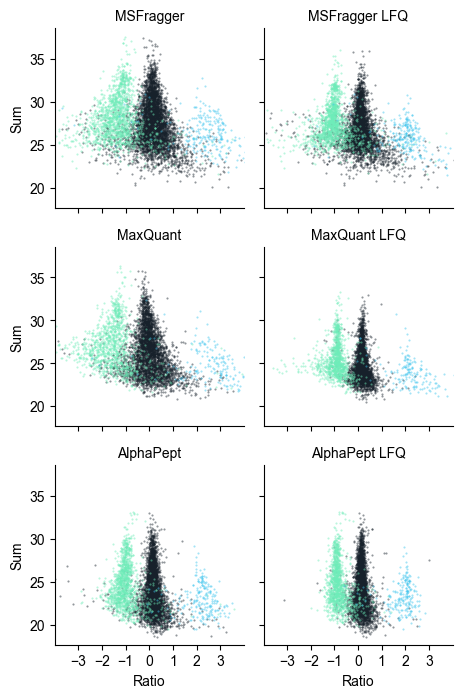

FragPipe
human Count 5,512 Median 0.04 Std 0.34
yeast Count 2,608 Median -0.86 Std 0.46
ecoli Count 311 Median 1.62 Std 0.61
MaxQuant
human Count 2,618 Median 0.12 Std 0.42
yeast Count 695 Median -0.88 Std 0.50
ecoli Count 62 Median 1.94 Std 0.50
AlphaPept
human Count 4,749 Median 0.08 Std 0.30
yeast Count 2,127 Median -0.89 Std 0.44
ecoli Count 238 Median 1.81 Std 0.61


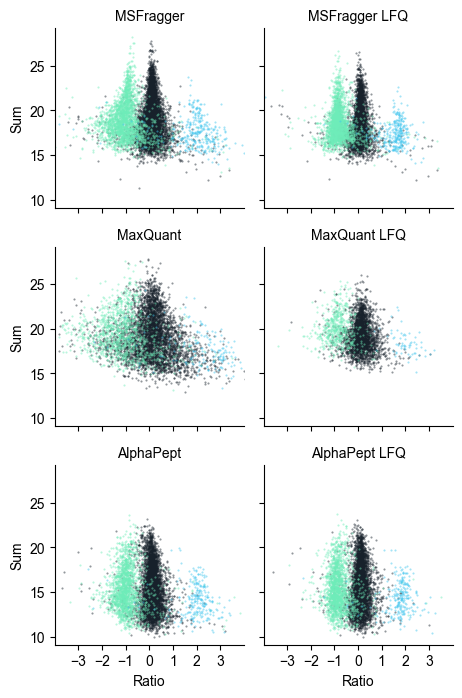

In [3]:
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

plt.rc('font',**{'family':'serif','serif':['Arial'], 'size':10})

text_poses = [(-6, 32, 5, 32), (-6, 20, 5, 20)]

"""
Manually read
MSFrager: 25.2 minutes | 174.2 Minutes
AlphaPept: 29.6 minutes | 263.8 minutes | 
MaxQuant: 95.05 | 636.92
"""

colors = [light_blue, teal, green, yellow]


colors_species = [dark_blue, green, light_blue] 

timings = ([25.2, 95.05, 29.6], [174.2, 636.92, 263.8])
timing_labels = ['FragPipe', 'MaxQuant','AlphaPept']

for ex_idx, experiment_id in enumerate(['PXD028735_Thermo', 'PXD028735_Bruker']):
    
    fig, axes = plt.subplots(3, 2, figsize=(2*figsize[0],3*figsize[0]), sharex=True, sharey=True)
    loaders = [load_msfragger, load_maxquant, load_alphapept]
    files = [ ms_files[ex_idx], mq_files[ex_idx], ap_files[ex_idx]]
    
    
    
    for software_idx, _ in enumerate(zip(loaders, files)): 
        print(timing_labels[software_idx])
        loader, file = _
        
        for i, lfq in enumerate([False, True]):
            ref, base_columns, ratio_columns = loader(file, lfq=lfq)

            to_plot = plot_df_from_ref(ref, base_columns, ratio_columns)

            #ToDO: pre_lfq 

            for species_idx, species in enumerate(['human', 'yeast', 'ecoli']):

                sub = to_plot[to_plot['species'] == species]
                cnt = (~sub['ratio'].isna()).sum()
                std_ = np.nanstd(to_plot[to_plot['species'] == species]['ratio_'])
                median_ = np.nanmedian(to_plot[to_plot['species'] == species]['ratio_'])
                
                if lfq:
                    print(f"{species} Count {cnt:,} Median {median_:.2f} Std {std_:.2f}")

                axes[software_idx, i].plot(sub['ratio_'], sub['sum_'], '.', alpha=0.5, color = colors_species[species_idx], markersize=1)

    for col in range(1):
        for row in range(3):
           
            ax = axes[row,col]
            ax.set_xticks(range(-3,4))
            ax.set_xlim([-4,4])
            ax.set_ylabel('Sum', **hfont)
            #ax.set_title(experiment_id, **hfont)
            
    axes[0,0].set_title('MSFragger', **hfont)
    axes[1,0].set_title('MaxQuant', **hfont)
    axes[2,0].set_title('AlphaPept', **hfont)
    
    axes[0,1].set_title('MSFragger LFQ', **hfont)
    axes[1,1].set_title('MaxQuant LFQ', **hfont)
    axes[2,1].set_title('AlphaPept LFQ', **hfont)
    
    axes[2,0].set_xlabel('Ratio', **hfont)
    axes[2,1].set_xlabel('Ratio', **hfont)
    plt.tight_layout()

    
    #fig.suptitle(experiment_id + '\n no LFQ           LFQ', **hfont) # or plt.suptitle('Main title')
    #fig.subplots_adjust(top=0.88)
    
    plt.xticks(**hfont)
    plt.yticks(**hfont)
    
    plt.savefig(f'./figures/08B_{experiment_id}.pdf')  
    plt.show()     

FragPipe
MaxQuant
AlphaPept


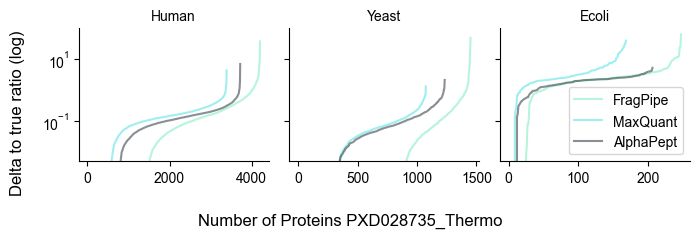

FragPipe
MaxQuant
AlphaPept


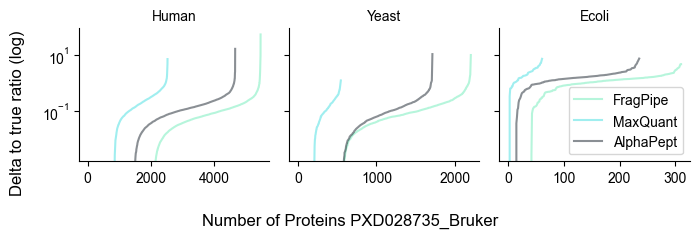

In [4]:
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

plt.rc('font',**{'family':'serif','serif':['Arial'], 'size':10})

text_poses = [(-6, 32, 5, 32), (-6, 20, 5, 20)]

ratio_dict = {}
ratio_dict['human'] = 1
ratio_dict['yeast'] = 0.5
ratio_dict['ecoli'] = 2

"""
Manually read
MSFrager: 25.2 minutes | 174.2 Minutes
AlphaPept: 29.6 minutes | 263.8 minutes | 
MaxQuant: 95.05 | 636.92
"""

colors = [green, teal, dark_blue, yellow]


colors_species = [dark_blue, green, light_blue] 

timings = ([25.2, 95.05, 29.6], [174.2, 636.92, 263.8])
timing_labels = ['FragPipe', 'MaxQuant','AlphaPept']

for ex_idx, experiment_id in enumerate(['PXD028735_Thermo', 'PXD028735_Bruker']):
    
    fig, axes = plt.subplots(1, 3, figsize=(3*figsize[0],1*figsize[0]), sharex=False, sharey=True)
    
    
    loaders = [load_msfragger, load_maxquant, load_alphapept]
    files = [ ms_files[ex_idx], mq_files[ex_idx], ap_files[ex_idx]]
    
    for software_idx, _ in enumerate(zip(loaders, files)): 
        print(timing_labels[software_idx])
        loader, file = _
        
        for i, lfq in enumerate([True]):
            ref, base_columns, ratio_columns = loader(file, lfq=lfq)

            to_plot = plot_df_from_ref(ref, base_columns, ratio_columns)

            #ToDO: pre_lfq 

            for species_idx, species in enumerate(['human', 'yeast', 'ecoli']):

                sub = to_plot[to_plot['species'] == species]

                sorted_ = (to_plot[to_plot['species'] == species]['ratio_nolog'] - ratio_dict[species]).sort_values().values
                
                axes[species_idx].plot(sorted_, alpha=0.5, color = colors[software_idx], markersize=1, label=timing_labels[software_idx])
                            
    axes[0].set_title('Human', **hfont)
    axes[1].set_title('Yeast', **hfont)
    axes[2].set_title('Ecoli', **hfont)
    
    plt.xticks(**hfont)
    plt.yticks(**hfont)
    
    plt.yscale('log')
    plt.legend()
    
    fig.supxlabel(f'Number of Proteins {experiment_id}')
    fig.supylabel('Delta to true ratio (log)')
    
    plt.tight_layout()
    
    plt.savefig(f'./figures/SI03_accuracy_{experiment_id}.pdf')  
    plt.show()     

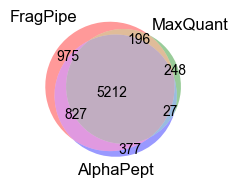

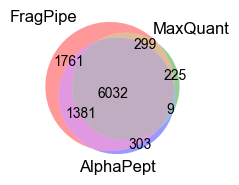

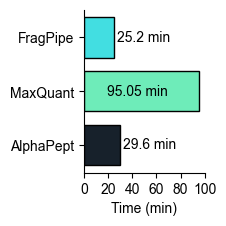

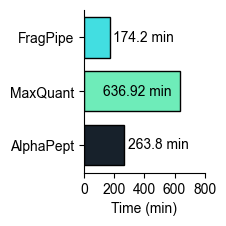

In [5]:
for ex_idx, experiment_id in enumerate(['PXD028735_Thermo', 'PXD028735_Bruker']):
    
    fig, ax = plt.subplots(figsize=figsize)
    prots = []
    
    loaders = [load_msfragger, load_maxquant, load_alphapept]
    files = [ms_files[ex_idx], mq_files[ex_idx], ap_files[ex_idx]]
    
    for software_idx, _ in enumerate(zip(loaders, files)): 
        loader, file = _
        
        ref, base_columns, ratio_columns = loader(file, lfq=True)
        
        prot = set([_.split(';')[0] for _ in ref.index.to_list()])
    
        prots.append(prot)

    venn3(prots, ('FragPipe', 'MaxQuant', 'AlphaPept'), ax=ax)

    plt.tight_layout()
    plt.savefig(f'./figures/08B_{experiment_id}_venn.pdf') 

    plt.show()


for ex_idx, experiment_id in enumerate(['PXD028735_Thermo', 'PXD028735_Bruker']):
    plt.figure(figsize=(2.363,2.363)) #60x60
    height=0.75
    data = timings[ex_idx][::-1]
    text = [f"{data[idx]} min" for idx, _ in enumerate(timing_labels[::-1])]

    for i in range(len(data)): 
        t = data[i]
        plt.barh(timing_labels[::-1][i], t, height, color = color_dict[timing_labels[::-1][i]], linewidth=1, edgecolor='black')

        if i == 1:
            plt.text(t*0.2, i, text[i], **hfont, va='center')
        else:
            plt.text(t*1.1, i, text[i], **hfont, va='center')

    plt.xlabel('Time (min)', **hfont)    
    if ex_idx == 0:
        plt.xticks([0, 20, 40, 60, 80, 100])
    else:
        plt.xticks([0, 200, 400 ,600, 800])

    plt.xticks(**hfont)
    plt.tight_layout()
    plt.savefig(f'./figures/08B_{experiment_id}_time.pdf') 

    plt.show()

## Peptide Level (w/ FDR)

F:/AP_Paper_Benchmark/PXD028735/PXD028735_Thermo_MSFragger/msfragger_results/LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Thermo_MSFragger/msfragger_results/LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Thermo_MSFragger/msfragger_results/LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Thermo_MSFragger/msfragger_results/LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Thermo_MSFragger/msfragger_results/LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Thermo_MSFragger/msfragger_results/LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03


C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:24: DtypeWarning: Columns (70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01
LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02
LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03
LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01


C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['protein'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['protein'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02
LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03


C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['protein'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['protein'].str.contains('ARA')


LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01
LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02
LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03


C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['Leading proteins'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['Leading proteins'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01
LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02


C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['Leading proteins'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['Leading proteins'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03


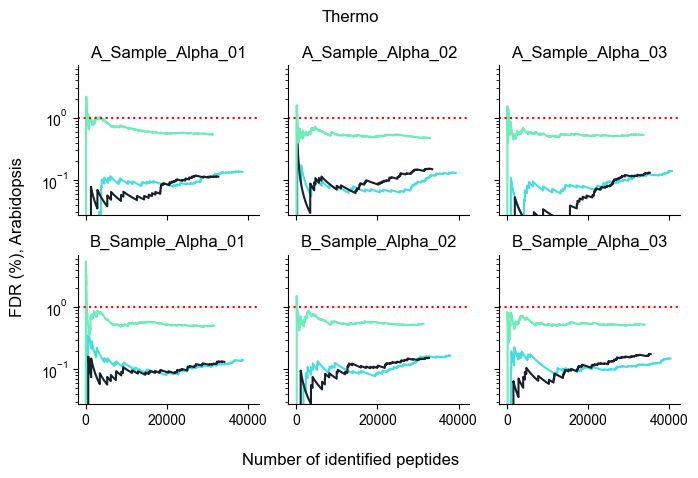

F:/AP_Paper_Benchmark/PXD028735/PXD028735_Bruker_MSFragger/msfragger_results/LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_01
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Bruker_MSFragger/msfragger_results/LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_02
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Bruker_MSFragger/msfragger_results/LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_03
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Bruker_MSFragger/msfragger_results/LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_01
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Bruker_MSFragger/msfragger_results/LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_02
F:/AP_Paper_Benchmark/PXD028735/PXD028735_Bruker_MSFragger/msfragger_results/LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_03


C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:24: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_01
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_03
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_02


C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['protein'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['protein'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_02
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_03
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_01


C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['protein'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['protein'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_01
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_01
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_03
LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_02


C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['Leading proteins'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['FalsePositive'] = x['Leading proteins'].str.contains('ARA')
C:\Users\admin\AppData\Local\Temp\ipykernel_20076\717024437.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

LFQ_timsTOFPro_PASEF_Condition_B_Sample_Alpha_03
LFQ_timsTOFPro_PASEF_Condition_A_Sample_Alpha_02


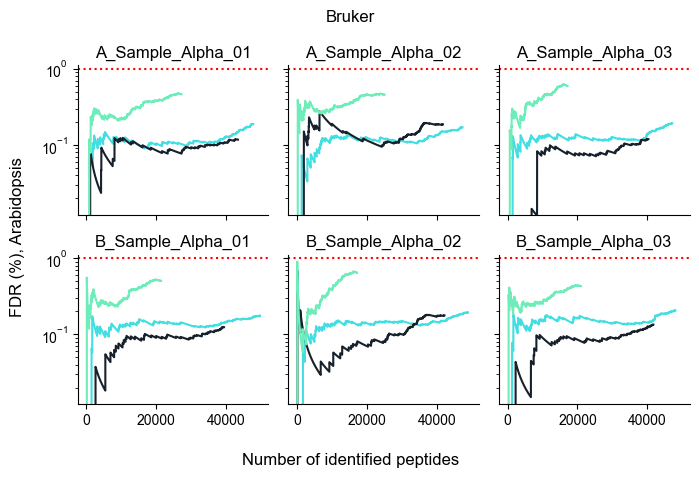

In [6]:
for placeholder in ['Thermo', 'Bruker']:        
    fig, axes = plt.subplots(2, 3, figsize=(3*figsize[0],2*figsize[0]), sharex=True, sharey=True)
    
    axes = axes.flat

    directory = f'F:/AP_Paper_Benchmark/PXD028735/PXD028735_{placeholder}_MSFragger/msfragger_results/'

    subfolders = [x[0] for x in os.walk(directory)][1:]
    for sub_idx, subfolder in enumerate(subfolders):
        path = os.path.join(directory, subfolder, 'peptide.tsv')

        x = pd.read_csv(path, sep='\t', low_memory=False)
        x['FalsePositive'] = x['Protein'].str.contains('ARA')
        x = x.sort_values(['Probability'], ascending=False)
        x['Rank'] = np.arange(len(x))+1
        x['FDR']= x['FalsePositive'].cumsum() / x['Rank']*100

        axes[sub_idx].plot(x['Rank'], x['FDR'], color=color_dict['FragPipe'])
        axes[sub_idx].set_title('_'.join(os.path.split(subfolder)[-1].split('_')[-4:]))
        print(subfolder)

    path = f'F:/AP_Paper_Benchmark/PXD028735/PXD028735_{placeholder}_AlphaPept/results_peptides.csv'

    df = pd.read_csv(path)

    for sub_idx, sn in enumerate(df['shortname'].unique()):
        print(sn)
        x = df[df['shortname'] == sn]


        x['FalsePositive'] = x['protein'].str.contains('ARA')
        x = x.sort_values(['score'], ascending=False)
        x['Rank'] = np.arange(len(x))+1
        x['FDR']= x['FalsePositive'].cumsum() / x['Rank']*100

        axes[sub_idx].plot(x['Rank'], x['FDR'], color=color_dict['AlphaPept'])

    path = f'F:/AP_Paper_Benchmark/PXD028735/PXD028735_{placeholder}_MaxQuant/combined/txt/evidence.txt'

    df = pd.read_csv(path, sep='\t', low_memory=False)

    for sub_idx, sn in enumerate(df['Raw file'].unique()):
        print(sn)
        x = df[df['Raw file'] == sn]

        x['FalsePositive'] = x['Leading proteins'].str.contains('ARA')
        x = x.sort_values(['Score'], ascending=False)
        x['Rank'] = np.arange(len(x))+1
        x['FDR']= x['FalsePositive'].cumsum() / x['Rank']*100

        axes[sub_idx].plot(x['Rank'], x['FDR'], color=color_dict['MaxQuant']) 

    fig.supxlabel('Number of identified peptides')
    fig.supylabel('FDR (%), Arabidopsis')
    plt.yscale('log')
    
    for ax in axes:
        ax.axhline(1, color='r', linestyle=':')
        
    
    plt.xticks(**hfont)
    plt.yticks(**hfont)
    fig.suptitle(placeholder)
    
    plt.tight_layout()
    
    plt.savefig(f'./figures/SI04_FDR_{placeholder}.pdf')  
    plt.show()     
    